<a href="https://colab.research.google.com/github/wazeer23/NLP-with-Python/blob/master/Amazon_Reviews_Sentiment_Analysis_Prediction_using_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load Data

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Nov  7 20:55:57 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    23W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import numpy as np 
import pandas as pd 

import bz2
import csv
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import os
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Conv1D
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding

In [33]:
import tensorflow_datasets as tfds
(ds_train, ds_test), ds_info = tfds.load('imdb_reviews', 
          split = (tfds.Split.TRAIN, tfds.Split.TEST),
          as_supervised=True,
          with_info=True)
print('info', ds_info)

INFO:absl:No config specified, defaulting to first: imdb_reviews/plain_text
INFO:absl:Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: imdb_reviews/plain_text/1.0.0
INFO:absl:Load dataset info from /tmp/tmpphnkg_mrtfds
INFO:absl:Field info.config_name from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.config_description from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.citation from disk and from code do not match. Keeping the one from code.
INFO:absl:Generating dataset imdb_reviews (/root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0)


INFO:absl:Downloading http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz into /root/tensorflow_datasets/downloads/ai.stanfor.edu_amaas_sentime_aclImdb_v1PaujRp-TxjBWz59jHXsMDm5WiexbxzaFQkEnXc3Tvo8.tar.gz.tmp.bff318ad9d6d40fe8c1ae3e15c5ade5a...
INFO:absl:Generating split train


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteRVYA3B/imdb_reviews-train.tfrecord


INFO:absl:Done writing /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteRVYA3B/imdb_reviews-train.tfrecord. Shard lengths: [25000]
INFO:absl:Generating split test


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteRVYA3B/imdb_reviews-test.tfrecord


INFO:absl:Done writing /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteRVYA3B/imdb_reviews-test.tfrecord. Shard lengths: [25000]
INFO:absl:Generating split unsupervised


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteRVYA3B/imdb_reviews-unsupervised.tfrecord


INFO:absl:Done writing /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteRVYA3B/imdb_reviews-unsupervised.tfrecord. Shard lengths: [50000]
INFO:absl:Skipping computing stats for mode ComputeStatsMode.SKIP.
INFO:absl:Constructing tf.data.Dataset for split (Split('train'), Split('test')), from /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
info tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=1.0.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, A

In [36]:
type(ds_train)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd


train = pd.read_csv('/content/drive/My Drive/training.csv')
test = pd.read_csv('/content/drive/My Drive/test.csv')

#/content/drive/My Drive/test.ft.txt

In [5]:
#combine to 1 dataframe
frames = [train, test]

In [6]:
df = pd.concat(frames)

In [7]:
df = df.reset_index()

In [8]:
#since the dataframe is very large, i will only grab a select number of rows
df = df.sample(frac=0.002, replace=True, random_state=42)
#df = df.sample(frac=0.070, replace=True, random_state=42)


In [9]:
df = df[['Sentence','Labels']]

In [10]:
df

,Sentence,Labels
2219110,fantasy and science fiction; what's better!?: ...,1
2768307,a little too convenient: this was my first jo ...,1
2229084,too complex and not very fun: after 90 minutes...,0
3511566,darth vader still #1!: no way in the world can...,0
2356330,shoddy customer service: i can't review this p...,0
...,...,...
3818971,contrived: the only thing right about this one...,0
2795571,"a master piece of art, design, and taste.: i a...",1
3623022,great book: i was fortunate enough to read to ...,1
3844020,the hummingbirds love this thing!: this is the...,1


Data Pre-processing

In [11]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

In [12]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each review.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Sentence'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 32020 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(df['Sentence'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (8000, 250)


In [ ]:

Y = pd.get_dummies(df['Labels']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (8000, 2)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(6400, 250) (6400, 2)
(1600, 250) (1600, 2)


In [ ]:
Y_train

array([[1, 0],
       [0, 1],
       [1, 0],
       ...,
       [1, 0],
       [0, 1],
       [0, 1]], dtype=uint8)

In [ ]:
df.Labels.value_counts()

1    4020
0    3980
Name: Labels, dtype: int64

Basic Embedding Model = Embedding + Flatten + Dense

In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(Flatten())
model.add(Dense(2, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 100)          5000000   
_________________________________________________________________
flatten (Flatten)            (None, 25000)             0         
_________________________________________________________________
dense (Dense)                (None, 2)                 50002     
Total params: 5,050,002
Trainable params: 5,050,002
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:

epochs = 5
batch_size = 30

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Epoch 1/5
6720/6720 [==============================] - 243s 36ms/step - loss: 0.2850 - acc: 0.8820 - val_loss: 0.2529 - val_acc: 0.9011
Epoch 2/5
6720/6720 [==============================] - 242s 36ms/step - loss: 0.1361 - acc: 0.9522 - val_loss: 0.2900 - val_acc: 0.8935
Epoch 3/5
6720/6720 [==============================] - 241s 36ms/step - loss: 0.0386 - acc: 0.9893 - val_loss: 0.3768 - val_acc: 0.8879
Epoch 4/5
6720/6720 [==============================] - 244s 36ms/step - loss: 0.0101 - acc: 0.9979 - val_loss: 0.4917 - val_acc: 0.8842
Epoch 5/5
6720/6720 [==============================] - 243s 36ms/step - loss: 0.0032 - acc: 0.9994 - val_loss: 0.5837 - val_acc: 0.8818


In [ ]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))


1750/1750 [==============================] - 5s 3ms/step - loss: 0.5894 - acc: 0.8811
Test set
  Loss: 0.589
  Accuracy: 0.881


In [ ]:
import matplotlib.pyplot as plt

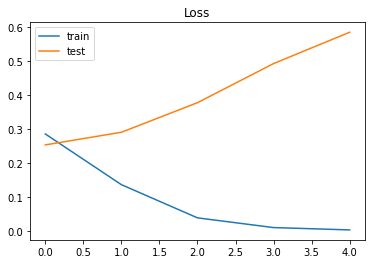

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

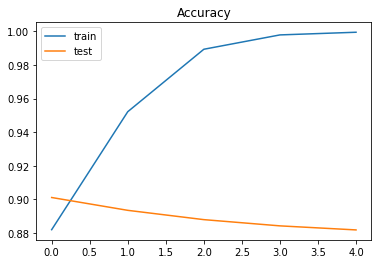

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

In [ ]:
y_pred = model.predict(X_test)


print('Basic Embedding AUC score:', roc_auc_score(Y_test, y_pred))

Basic Embedding AUC score: 0.9481804803451632


In [ ]:
first_model_score = roc_auc_score(Y_test, y_pred)

In [ ]:
first_model_score

0.9481804803451632

In [ ]:
test_pred =  model.predict(X_test)

In [ ]:
import numpy as np
rounded_test=np.argmax(Y_test, axis=1)
rounded_test[1]

1

In [ ]:
import numpy as np
rounded_pred=np.argmax(test_pred, axis=1)
rounded_pred[1]

1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


Text(0.5, 1.0, 'Basic Embedding')

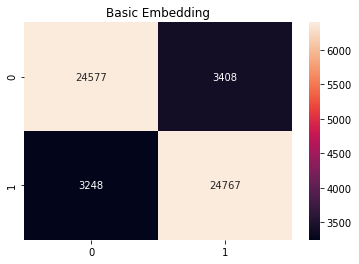

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
cf_matrix = confusion_matrix(rounded_test, rounded_pred)
import seaborn as sns
import matplotlib.pyplot as plt
#labels = ['Negative','Positive']
sns.heatmap(cf_matrix, annot=True, fmt = 'd', vmax = 6400)
ax = plt.axes()
ax.set_title('Basic Embedding')

Adding Spatial 1D Dropout  

In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(Flatten())
model.add(Dense(2, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 250, 100)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 50002     
Total params: 5,050,002
Trainable params: 5,050,002
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:

epochs = 5
batch_size = 30

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Epoch 1/5
6720/6720 [==============================] - 246s 37ms/step - loss: 0.2880 - acc: 0.8809 - val_loss: 0.2525 - val_acc: 0.9018
Epoch 2/5
6720/6720 [==============================] - 245s 36ms/step - loss: 0.1502 - acc: 0.9453 - val_loss: 0.2770 - val_acc: 0.8994
Epoch 3/5
6720/6720 [==============================] - 244s 36ms/step - loss: 0.0568 - acc: 0.9824 - val_loss: 0.3433 - val_acc: 0.8930
Epoch 4/5
6720/6720 [==============================] - 242s 36ms/step - loss: 0.0230 - acc: 0.9936 - val_loss: 0.4258 - val_acc: 0.8898
Epoch 5/5
6720/6720 [==============================] - 242s 36ms/step - loss: 0.0112 - acc: 0.9970 - val_loss: 0.5018 - val_acc: 0.8880


In [ ]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))



1750/1750 [==============================] - 5s 3ms/step - loss: 0.5173 - acc: 0.8854
Test set
  Loss: 0.517
  Accuracy: 0.885


In [ ]:

y_pred = model.predict(X_test)


print('Basic Embedding + Spatial Dropout AUC score:', roc_auc_score(Y_test, y_pred))


Basic Embedding + Spatial Dropout AUC score: 0.9504914478451221


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


Text(0.5, 1.0, 'Basic Embedding + Spacial Dropout Classification Report')

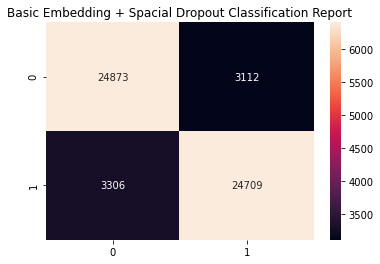

In [ ]:

test_pred =  model.predict(X_test)

rounded_pred=np.argmax(test_pred, axis=1)
rounded_pred[1]
cf_matrix = confusion_matrix(rounded_test, rounded_pred)
sns.heatmap(cf_matrix, annot=True, fmt = 'd', vmax = 6400)
ax = plt.axes()
ax.set_title('Basic Embedding + Spacial Dropout Classification Report')

In [ ]:
#Roc score

LSTM

In [ ]:
  model = Sequential()
  model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
  model.add(SpatialDropout1D(0.2))
  model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
  model.add(Dense(2, activation='softmax'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 5,080,602
Trainable params: 5,080,602
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:

epochs = 5
batch_size = 30

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Epoch 1/5
6720/6720 [==============================] - 2939s 437ms/step - loss: 0.2606 - accuracy: 0.8944 - val_loss: 0.1881 - val_accuracy: 0.9290
Epoch 2/5
6720/6720 [==============================] - 2949s 439ms/step - loss: 0.1606 - accuracy: 0.9399 - val_loss: 0.1877 - val_accuracy: 0.9275
Epoch 3/5
6720/6720 [==============================] - 2936s 437ms/step - loss: 0.1193 - accuracy: 0.9571 - val_loss: 0.1853 - val_accuracy: 0.9330
Epoch 4/5
6720/6720 [==============================] - 2956s 440ms/step - loss: 0.0887 - accuracy: 0.9690 - val_loss: 0.2028 - val_accuracy: 0.9333
Epoch 5/5
6720/6720 [==============================] - 2946s 438ms/step - loss: 0.0670 - accuracy: 0.9770 - val_loss: 0.2252 - val_accuracy: 0.9327


In [ ]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))


1750/1750 [==============================] - 130s 74ms/step - loss: 0.2342 - accuracy: 0.9275
Test set
  Loss: 0.234
  Accuracy: 0.927


In [ ]:

y_pred = model.predict(X_test)


print('LSTM AUC score:', roc_auc_score(Y_test, y_pred))


LSTM AUC score: 0.9757300922057024


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


Text(0.5, 1.0, 'LSTM')

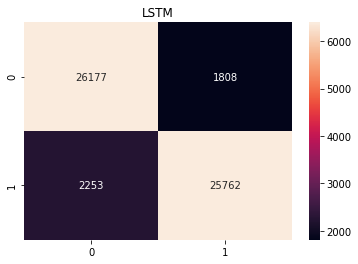

In [ ]:
test_pred =  model.predict(X_test)

rounded_pred=np.argmax(test_pred, axis=1)
rounded_pred[1]
cf_matrix = confusion_matrix(rounded_test, rounded_pred)
sns.heatmap(cf_matrix, annot=True, fmt = 'd', vmax = 6400)
ax = plt.axes()
ax.set_title('LSTM')

Bidirectional LSTM

In [ ]:
  model = Sequential()
  model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
  model.add(SpatialDropout1D(0.2))
  model.add(Bidirectional(LSTM(100)))
  model.add(Dense(2, activation='softmax'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 250, 100)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               160800    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 402       
Total params: 5,161,202
Trainable params: 5,161,202
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:

epochs = 5
batch_size = 30

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Epoch 1/5
6720/6720 [==============================] - 409s 61ms/step - loss: 0.2491 - accuracy: 0.9004 - val_loss: 0.1894 - val_accuracy: 0.9305
Epoch 2/5
6720/6720 [==============================] - 408s 61ms/step - loss: 0.1503 - accuracy: 0.9441 - val_loss: 0.1754 - val_accuracy: 0.9337
Epoch 3/5
6720/6720 [==============================] - 408s 61ms/step - loss: 0.1062 - accuracy: 0.9620 - val_loss: 0.1999 - val_accuracy: 0.9345
Epoch 4/5
6720/6720 [==============================] - 408s 61ms/step - loss: 0.0735 - accuracy: 0.9748 - val_loss: 0.2101 - val_accuracy: 0.9312
Epoch 5/5
6720/6720 [==============================] - 406s 60ms/step - loss: 0.0505 - accuracy: 0.9832 - val_loss: 0.2564 - val_accuracy: 0.9289


In [ ]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))



1750/1750 [==============================] - 20s 11ms/step - loss: 0.2607 - accuracy: 0.9264
Test set
  Loss: 0.261
  Accuracy: 0.926


In [ ]:

y_pred = model.predict(X_test)


print('Bi-Directional LSTM AUC score:', roc_auc_score(Y_test, y_pred))

Bi-Directional LSTM AUC score: 0.974198007901214


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


Text(0.5, 1.0, 'Bi-Directional LSTM')

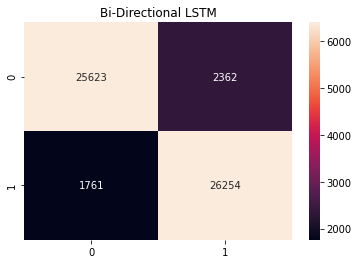

In [ ]:

test_pred =  model.predict(X_test)

rounded_pred=np.argmax(test_pred, axis=1)
rounded_pred[1]
cf_matrix = confusion_matrix(rounded_test, rounded_pred)
sns.heatmap(cf_matrix, annot=True, fmt = 'd', vmax = 6400)
ax = plt.axes()
ax.set_title('Bi-Directional LSTM')

CNN

In [ ]:
num_kernels = 260
kernel_size = 3
hidden_dims = 300


In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(Dropout(0.2))
model.add(Conv1D(num_kernels,kernel_size, padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims))
model.add(Dropout(0.5))
model.add(Dense(2, activation='relu'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
print (model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
dropout (Dropout)            (None, 250, 100)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 248, 260)          78260     
_________________________________________________________________
global_max_pooling1d (Global (None, 260)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 300)               78300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                

In [ ]:

epochs = 5
batch_size = 30

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Epoch 1/5
6720/6720 [==============================] - 242s 36ms/step - loss: 6.4757 - accuracy: 0.5464 - val_loss: 7.7062 - val_accuracy: 0.4975
Epoch 2/5
6720/6720 [==============================] - 242s 36ms/step - loss: 7.6956 - accuracy: 0.4982 - val_loss: 7.7062 - val_accuracy: 0.4975
Epoch 3/5
6720/6720 [==============================] - 243s 36ms/step - loss: 7.6955 - accuracy: 0.4982 - val_loss: 7.7062 - val_accuracy: 0.4975
Epoch 4/5
6720/6720 [==============================] - 244s 36ms/step - loss: 7.6956 - accuracy: 0.4982 - val_loss: 7.7062 - val_accuracy: 0.4975
Epoch 5/5
6720/6720 [==============================] - 246s 37ms/step - loss: 7.6956 - accuracy: 0.4982 - val_loss: 7.7062 - val_accuracy: 0.4975


In [ ]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))



1750/1750 [==============================] - 6s 3ms/step - loss: 7.6726 - accuracy: 0.4997
Test set
  Loss: 7.673
  Accuracy: 0.500


In [ ]:

y_pred = model.predict(X_test)


print('Basic CNN AUC score:', roc_auc_score(Y_test, y_pred))

Basic CNN AUC score: 0.6784757642309271


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


Text(0.5, 1.0, '1-D CNN')

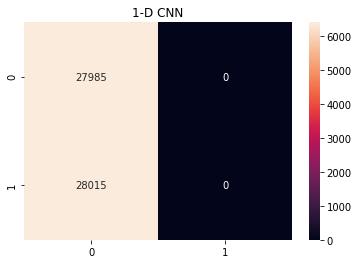

In [ ]:

test_pred =  model.predict(X_test)

rounded_pred=np.argmax(test_pred, axis=1)
rounded_pred[1]
cf_matrix = confusion_matrix(rounded_test, rounded_pred)
sns.heatmap(cf_matrix, annot=True, fmt = 'd', vmax = 6400)
ax = plt.axes()
ax.set_title('1-D CNN')

GLovE Pre-Trained Model

In [ ]:
  
from numpy import array, asarray, zeros



In [ ]:
# load glove model
inMemoryGlove = dict()
f = open('/content/drive/My Drive/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefficients = asarray(values[1:], dtype='float32')
    inMemoryGlove[word] = coefficients
f.close()
print(len(inMemoryGlove))

400000


In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Sentence'].values)
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print('Found %s unique tokens.' % len(word_index))


Found 32020 unique tokens.


In [ ]:

X = tokenizer.texts_to_sequences(df['Sentence'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

encodeDocuments = X

Shape of data tensor: (8000, 250)


In [ ]:

Y = pd.get_dummies(df['Labels']).values
print('Shape of label tensor:', Y.shape)


Shape of label tensor: (8000, 2)


In [ ]:

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(6400, 250) (6400, 2)
(1600, 250) (1600, 2)


In [ ]:
# create coefficient matrix for training data
trainingToEmbeddings = zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    gloveVector = inMemoryGlove.get(word)
    if gloveVector is not None:
        trainingToEmbeddings[i] = gloveVector

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 100, weights=[trainingToEmbeddings], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2, return_sequences = True))
model.add(LSTM(50, dropout=0.2, recurrent_dropout=0.2))
#model.add(Flatten())
model.add(Dense(2, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 250, 100)          3202100   
_________________________________________________________________
lstm_1 (LSTM)                (None, 250, 100)          80400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 102       
Total params: 3,312,802
Trainable params: 110,702
Non-trainable params: 3,202,100
_________________________________________________________________
None


In [ ]:
epochs = 5
batch_size = 30

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Epoch 1/5
192/192 [==============================] - 133s 692ms/step - loss: 0.6366 - acc: 0.6314 - val_loss: 0.5338 - val_acc: 0.7578
Epoch 2/5
192/192 [==============================] - 133s 690ms/step - loss: 0.6643 - acc: 0.5974 - val_loss: 0.6742 - val_acc: 0.5453
Epoch 3/5
192/192 [==============================] - 131s 683ms/step - loss: 0.6190 - acc: 0.6743 - val_loss: 0.6185 - val_acc: 0.6719
Epoch 4/5
192/192 [==============================] - 130s 677ms/step - loss: 0.5218 - acc: 0.7653 - val_loss: 0.4583 - val_acc: 0.8000
Epoch 5/5
192/192 [==============================] - 130s 676ms/step - loss: 0.5204 - acc: 0.7594 - val_loss: 0.4746 - val_acc: 0.7797


In [ ]:

y_pred = model.predict(X_test)


print('GloVe Model AUC Score:', roc_auc_score(Y_test, y_pred))

GloVe Model AUC Score: 0.8891072277549795


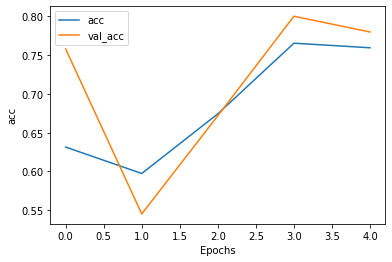

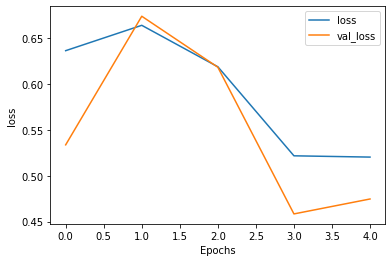

In [ ]:
import matplotlib.pyplot as plt

import numpy as np
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "acc")
plot_graphs(history, "loss")

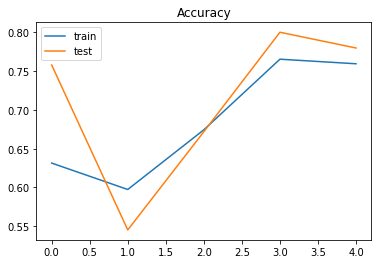

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

In [ ]:

test_pred =  model.predict(X_test)

rounded_pred=np.argmax(test_pred, axis=1)
rounded_pred[1]
cf_matrix = confusion_matrix(rounded_test, rounded_pred)
sns.heatmap(cf_matrix, annot=True, fmt = 'd', vmax = 6400)
ax = plt.axes()
ax.set_title('GlovE')

NameError: ignored

BERT

In [14]:
!pip install transformers

     |████████████████████████████████| 1.3MB 8.8MB/s 
     |████████████████████████████████| 890kB 17.4MB/s 
     |████████████████████████████████| 1.1MB 59.8MB/s 
     |████████████████████████████████| 2.9MB 65.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=e6dc2e1cffdbdc798f28221f2aaf2fee5f74e378bfc75a434e7b085dd90c48c2
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [15]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import transformers

In [16]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
    
    return np.array(all_tokens)

In [17]:
def build_model(transformer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [18]:
%%time
transformer_layer = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_transform', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.



CPU times: user 5.83 s, sys: 1.42 s, total: 7.26 s
Wall time: 19.1 s


In [19]:
model = build_model(transformer_layer, max_len=250)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 250)]             0         
_________________________________________________________________
tf_distil_bert_model (TFDist ((None, 250, 768),)       66362880  
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 768)]             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 769       
Total params: 66,363,649
Trainable params: 66,363,649
Non-trainable params: 0
_________________________________________________________________


In [20]:
X = df['Sentence']

Y = df['Labels']

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(6400,) (6400,)
(1600,) (1600,)


In [22]:
train_input = bert_encode(X_train.values, tokenizer, max_len=250)
test_input = bert_encode(X_test.values, tokenizer, max_len=250)
train_labels = Y_train.values

In [23]:

epochs = 1
batch_size = 30

history = model.fit(train_input, train_labels, epochs=epochs, batch_size=batch_size,validation_split=0.1)

192/192 [==============================] - 48s 253ms/step - loss: 0.3452 - accuracy: 0.8398 - val_loss: 0.1818 - val_accuracy: 0.9328


In [24]:

test_pred = model.predict(test_input, verbose = 1)

y_pred = test_pred.round().astype(int)



50/50 [==============================] - 4s 78ms/step


In [25]:
print('BERT AUC Score:', roc_auc_score(Y_test, y_pred))

BERT AUC Score: 0.9265213692323091


NameError: ignored

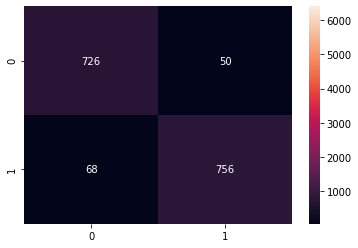

In [30]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
cf_matrix = confusion_matrix(Y_test, y_pred)
sns.heatmap(cf_matrix, annot=True, fmt = 'd', vmax = 6400)
ax = plt.axes()
ax.set_title('BERT')

In [31]:
%%time
transformer_layer = transformers.OpenAIGPTTokenizer.from_pretrained('openai-gpt')
tokenizer = transformers.OpenAIGPTTokenizer.from_pretrained('openai-gpt')

ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.


ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.


CPU times: user 250 ms, sys: 31.9 ms, total: 282 ms
Wall time: 3.26 s


In [32]:
model = build_model(transformer_layer, max_len=160)
model.summary()

AssertionError: ignored

In [ ]:
!jupyter nbconvert --to html test.ipynb

[NbConvertApp] WARNING | pattern u'test.ipynb' matched no files
This application is used to convert notebook files (*.ipynb) to various other
formats.


Options
-------

Arguments that take values are actually convenience aliases to full
Configurables, whose aliases are listed on the help line. For more information
on full configurables, see '--help-all'.

--execute
    Execute the notebook prior to export.
--allow-errors
    Continue notebook execution even if one of the cells throws an error and include the error message in the cell output (the default behaviour is to abort conversion). This flag is only relevant if '--execute' was specified, too.
--no-input
    Exclude input cells and output prompts from converted document. 
    This mode is ideal for generating code-free reports.
--stdout
    Write notebook output to stdout instead of files.
--stdin
    read a single notebook file from stdin. Write the resulting notebook with default basename 'notebook.*'
--inplace
    Run nbconver

In [ ]:
import pandas as pd

In [ ]:
results = pd.read_csv('results.csv')

FileNotFoundError: ignored

In [ ]:
results

In [ ]:
import seaborn as sns

In [ ]:
ax = sns.barplot(x="AUC Score", y="Architecture", data=results, dodge = False, palette="icefire")
ax.set(xlim=(0.73, 1))
ax.set_title('Model AUC Score Comparision')